In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import os
import cv2

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from keras import regularizers
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

main_accent_colour = "#b366ff"
dim_colour="darkgrey"
main_palette = ["#FBE5C0", "#DD9A30", "#F88379", "#FF6FC2", "purple", "#D086F6", "#B0D2C2", "#4C5D70", "#6FA2CE", "#382D24", "#3ACF3A", "#7D7D00"]

# Preprocessing 

In [3]:
train_dir = 'archive/train/'
test_dir = 'archive/test/'

row = 48
col = 48
classes = len(os.listdir('archive/train/'))

In [4]:
print("Train Set :")

train_count = []
for folder in os.listdir(train_dir) :
    print(folder, "archive/train/", len(os.listdir(train_dir+folder)), "image")
    train_count.append(len(os.listdir(train_dir+folder)))
    
print()

test_count = []
print("Test Set :")
for folder in os.listdir(test_dir) :
    print(folder, "archive/test/", len(os.listdir(test_dir+folder)), "images")
    test_count.append(len(os.listdir(test_dir+folder)))

Train Set :
sad archive/train/ 4830 image
angry archive/train/ 3995 image
happy archive/train/ 7215 image
surprise archive/train/ 3171 image
neutral archive/train/ 4965 image
disgust archive/train/ 436 image
fear archive/train/ 4097 image

Test Set :
sad archive/test/ 1247 images
angry archive/test/ 958 images
happy archive/test/ 1774 images
surprise archive/test/ 831 images
neutral archive/test/ 1233 images
disgust archive/test/ 111 images
fear archive/test/ 1024 images


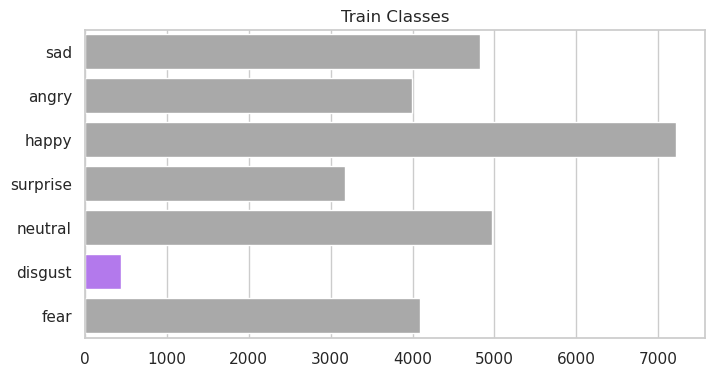

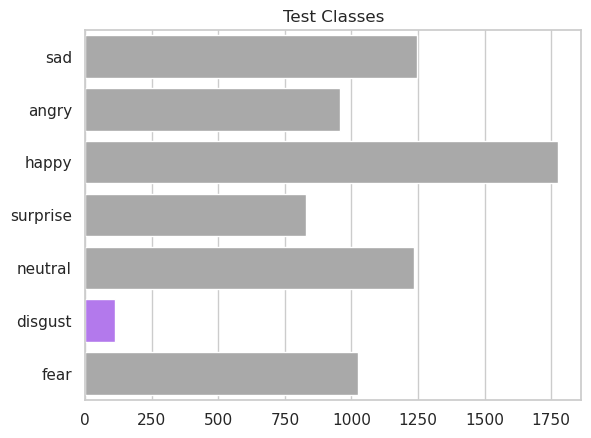

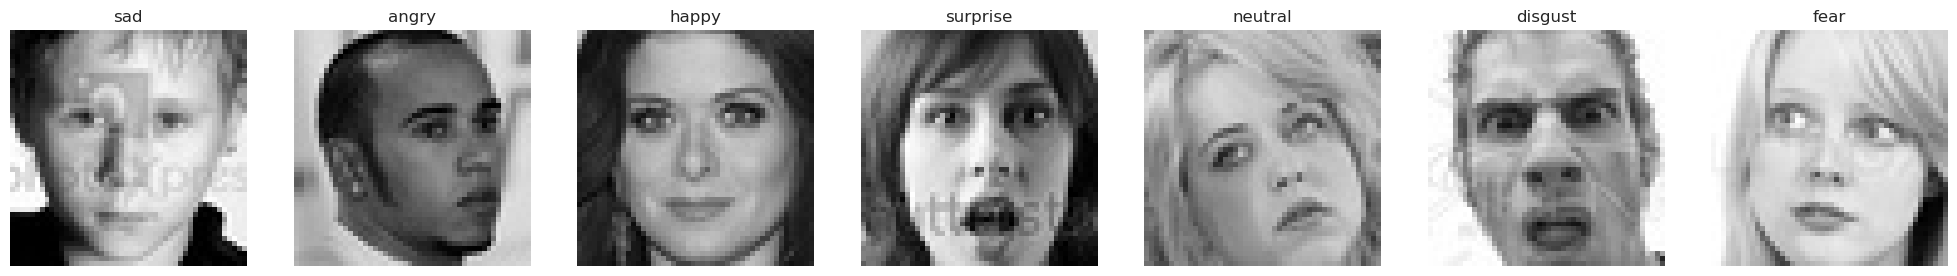

In [5]:
vals = ["disgust"]
palette = {c: dim_colour if c not in vals else main_accent_colour for c in os.listdir(train_dir)}

plt.figure(figsize=(8,4))

ax = sns.barplot(y=os.listdir(train_dir),
                 x=train_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Train Classes')

plt.show()

print()

ax = sns.barplot(y=os.listdir(test_dir),
                 x=test_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Test Classes')

plt.show()

print()

plt.figure(figsize=(25,25))

i = 1
for folder in os.listdir(train_dir):
    
    img = load_img((train_dir + folder +'/'+ os.listdir(train_dir + folder)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(folder)
    plt.axis('off')
    i += 1
    
plt.show()

# Preprocessing

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [10]:
def get_model(input_size, classes=7):
    
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [11]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_2 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)      

2023-09-01 02:58:45.546258: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 126877696 exceeds 10% of free system memory.
2023-09-01 02:58:45.591799: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 126877696 exceeds 10% of free system memory.
/home/evaface/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


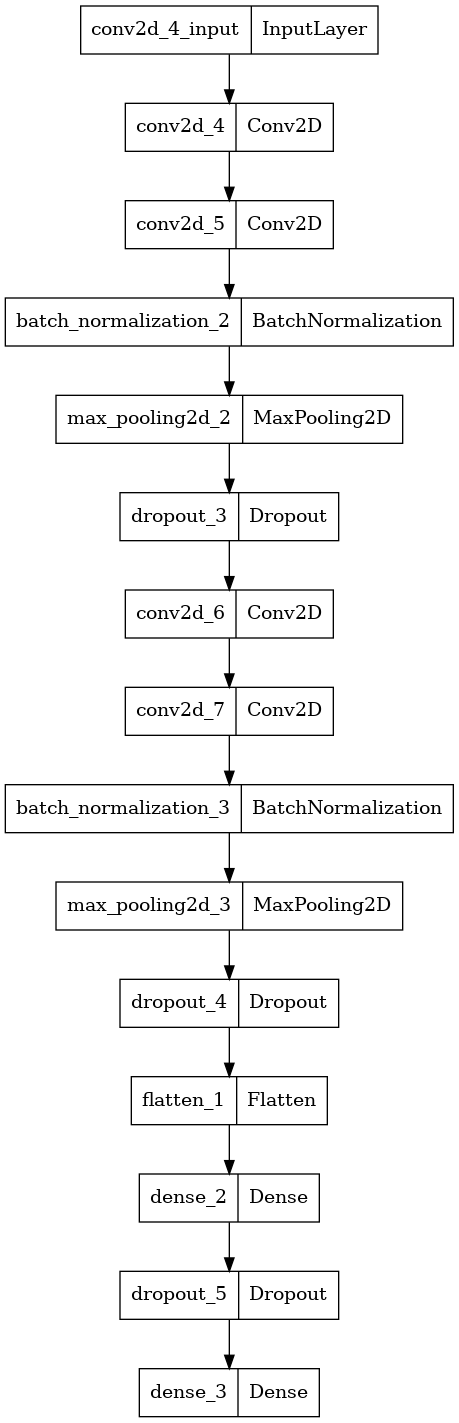

In [12]:
plot_model(fernet, show_layer_names=True)

# Checkpoint

In [13]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [15]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                  validation_data=test_set,
                  epochs=10,
                  callbacks=callbacks,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)

Epoch 1/10
448/448 [==============================] - ETA: 0s - loss: 4.1924 - accuracy: 0.2796
Epoch 1: val_loss improved from inf to 5.89307, saving model to ferNet.h5


/home/evaface/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - 491s 1s/step - loss: 4.1924 - accuracy: 0.2796 - val_loss: 5.8931 - val_accuracy: 0.1504 - lr: 1.0000e-04
Epoch 2/10
448/448 [==============================] - ETA: 0s - loss: 3.4389 - accuracy: 0.3389
Epoch 2: val_loss improved from 5.89307 to 3.05564, saving model to ferNet.h5
448/448 [==============================] - 595s 1s/step - loss: 3.4389 - accuracy: 0.3389 - val_loss: 3.0556 - val_accuracy: 0.4044 - lr: 1.0000e-04
Epoch 3/10
448/448 [==============================] - ETA: 0s - loss: 2.9301 - accuracy: 0.3724
Epoch 3: val_loss improved from 3.05564 to 2.60296, saving model to ferNet.h5
448/448 [==============================] - 449s 1s/step - loss: 2.9301 - accuracy: 0.3724 - val_loss: 2.6030 - val_accuracy: 0.4282 - lr: 1.0000e-04
Epoch 4/10
448/448 [==============================] - ETA: 0s - loss: 2.5181 - accuracy: 0.4075
Epoch 4: val_loss improved from 2.60296 to 2.31682, saving model to ferNet.h5
448/448 [======================

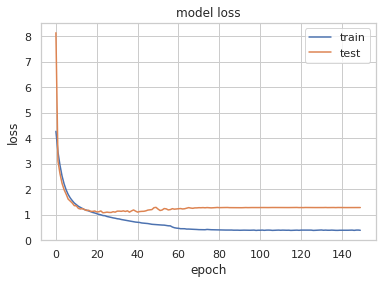

In [12]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

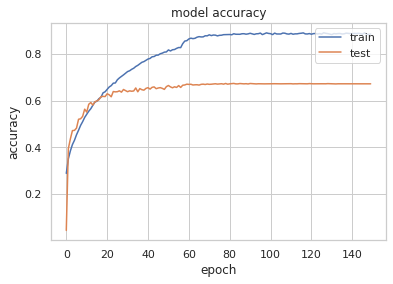

In [13]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [14]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 6s 51ms/step - loss: 1.2828 - accuracy: 0.6718
final train accuracy = 95.74 , validation accuracy = 67.18


# Result

Confusion Matrix
[[ 544   69  540 1015  688  689  450]
 [  54    6   70  117   75   67   47]
 [ 570   50  560 1045  731  673  468]
 [ 955  105 1015 1837 1266 1223  814]
 [ 714   69  688 1250  870  849  525]
 [ 669   73  672 1224  864  772  556]
 [ 457   56  430  813  560  530  325]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3995
     disgust       0.01      0.01      0.01       436
        fear       0.14      0.14      0.14      4097
       happy       0.25      0.25      0.25      7215
     neutral       0.17      0.18      0.17      4965
         sad       0.16      0.16      0.16      4830
    surprise       0.10      0.10      0.10      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



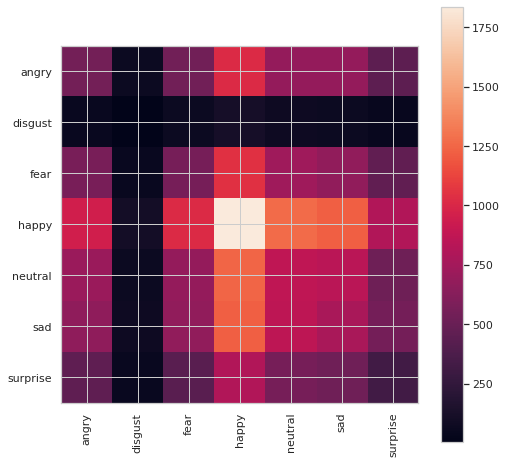

In [15]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix
[[148  12 131 233 173 153 108]
 [ 21   1  17  31  20  14   7]
 [138  15 121 238 210 192 110]
 [238  22 218 449 339 280 228]
 [179   7 133 305 244 225 140]
 [183  10 134 349 236 202 133]
 [113   9  96 210 138 161 104]]
Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.15      0.15       958
     disgust       0.01      0.01      0.01       111
        fear       0.14      0.12      0.13      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.18      0.20      0.19      1233
         sad       0.16      0.16      0.16      1247
    surprise       0.13      0.13      0.13       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.17      0.18      0.18      7178



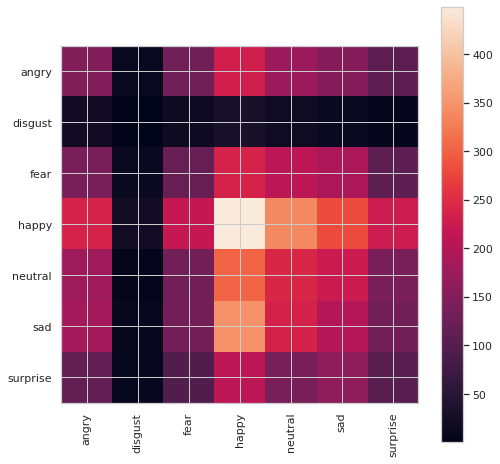

In [16]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

# Recommending Music

In [17]:
mood_music = pd.read_csv("../input/spotify-music-data-to-identify-the-moods/data_moods.csv")
mood_music = mood_music[['name','artist','mood']]
mood_music.head()

name          artist       mood
0                                         1999          Prince      Happy
1                                           23  Blonde Redhead        Sad
2                                     9 Crimes     Damien Rice        Sad
3                               99 Luftballons            Nena      Happy
4  A Boy Brushed Red Living In Black And White       Underoath  Energetic

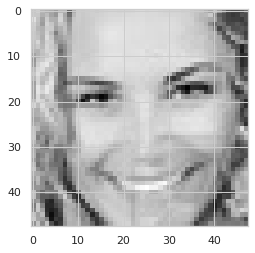

In [18]:
image = cv2.imread('../input/fer2013/test/happy/PrivateTest_10077120.jpg',cv2.IMREAD_GRAYSCALE)

plt.imshow(image,cmap='gray')
plt.show()

In [19]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=fernet.predict(img) 
result=np.argmax(predict_x,axis=1)
result[0]

3

In [20]:
if(result[0]==0 or result[0]==1 or result[0]==2 ):
    #for angery,disgust,fear
    filter1=mood_music['mood']=='Calm'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==3 or result[0]==4):
    #for happy, neutral
    filter1=mood_music['mood']=='Happy'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==5):
       #for Sad
    filter1=mood_music['mood']=='Sad'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==6):
     #for surprise
    filter1=mood_music['mood']=='Energetic'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)

index                      name              artist   mood
0    563          The Safety Dance    Men Without Hats  Happy
1    503  Start Me Up - Remastered  The Rolling Stones  Happy
2    123              Daar Gaat Ze            Clouseau  Happy
3    533     Talking In Your Sleep       The Romantics  Happy
4    497               Someone New         Thomas Gold  Happy